TO DO LIST:


-inizio random forest


In [1]:
!pip install --upgrade gdown
!gdown --id 10GjRPTI-FP3cBz1VIJhUgWoNF4thC3Gu

c:\Users\hp\Desktop\University\ML\venv\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10GjRPTI-FP3cBz1VIJhUgWoNF4thC3Gu
To: c:\Users\hp\Desktop\University\MachineLearning\KDDTrainClean.csv

  0%|          | 0.00/17.2M [00:00<?, ?B/s]
  6%|▌         | 1.05M/17.2M [00:00<00:01, 8.84MB/s]
 18%|█▊        | 3.15M/17.2M [00:00<00:00, 14.5MB/s]
 30%|███       | 5.24M/17.2M [00:00<00:00, 17.0MB/s]
 43%|████▎     | 7.34M/17.2M [00:00<00:00, 16.4MB/s]
 55%|█████▍    | 9.44M/17.2M [00:00<00:00, 16.4MB/s]
 70%|███████   | 12.1M/17.2M [00:00<00:00, 18.1MB/s]
 82%|████████▏ | 14.2M/17.2M [00:00<00:00, 17.4MB/s]
 94%|█████████▍| 16.3M/17.2M [00:01<00:00, 11.9MB/s]
100%|██████████| 17.2M/17.2M [00:01<00:00, 12.1MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

Import del data set e conta delle varie classi presenti. upload su git

In [ ]:
import pandas as pd

# Load the train dataset
df = pd.read_csv('KDDTrainClean.csv')


# Check for missing values in the train dataset
print("Missing values in Train set:")
print(df.isnull().sum())

Missing values in Train set:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate 

Inizio a standardizzare le label numeriche con media zero e varianza unitaria

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(df, numeric_cols=None, verbose=False):
    """
    Normalizza le colonne numeriche di un DataFrame usando MinMaxScaler,
    lasciando inalterate le altre colonne.

    Se numeric_cols non viene fornita, la funzione rileva automaticamente tutte
    le colonne numeriche.

    Parameters:
        df : pandas.DataFrame
            Il DataFrame di input.
        numeric_cols : list of str, optional
            Lista dei nomi delle colonne da normalizzare. Se None, vengono automaticamente
            rilevate tutte le colonne numeriche.
        verbose : bool, optional (default False)
            Se True, la funzione stamperà un messaggio di conferma indicando le colonne
            normalizzate, una per linea.

    Returns:
        df_normalized : pandas.DataFrame
            Nuovo DataFrame con le colonne numeriche normalizzate.
        scaler : MinMaxScaler
            L'istanza dello scaler utilizzata per la trasformazione.
    """
    # Crea una copia del DataFrame per non modificare l'originale
    df_normalized = df.copy()

    # Se non viene fornita una lista, rileva automaticamente le colonne numeriche
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Crea lo scaler e applica la trasformazione alle colonne numeriche
    scaler = MinMaxScaler()
    df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])

    # Se verbose è True, stampa un messaggio con le colonne normalizzate, una per riga
    if verbose:
        print("Successfully normalized the following columns:")
        for col in numeric_cols:
            print(col)

    return df_normalized, scaler

# Esempio di utilizzo:
# Assumendo che il DataFrame originale si chiami df
df_normalized, scaler = normalize_dataframe(df, verbose=True)


Successfully normalized the following columns:
duration
src_bytes
dst_bytes
land
wrong_fragment
urgent
hot
num_failed_logins
logged_in
num_compromised
root_shell
su_attempted
num_root
num_file_creations
num_shells
num_access_files
num_outbound_cmds
is_host_login
is_guest_login
count
srv_count
serror_rate
srv_serror_rate
rerror_rate
srv_rerror_rate
same_srv_rate
diff_srv_rate
srv_diff_host_rate
dst_host_count
dst_host_srv_count
dst_host_same_srv_rate
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_srv_diff_host_rate
dst_host_serror_rate
dst_host_srv_serror_rate
dst_host_rerror_rate
dst_host_srv_rerror_rate


funzione per duplicare migliore

In [ ]:
import pandas as pd

def set_rare_elements_count(df, desired_count, verbose=True):
    """
    Per ogni classe presente nella colonna 'label' del DataFrame, se il numero di occorrenze
    è inferiore a desired_count, aggiunge esattamente (desired_count - current_count) copie dei campioni
    originali, in modo da ottenere esattamente desired_count istanze per quella classe.

    Parameters:
        df : pandas.DataFrame
            Il dataset originale.
        desired_count : int
            Il numero minimo desiderato di campioni per ciascuna classe.
        verbose : bool, optional
            Se True, stampa un messaggio per ogni classe aumentata con il conteggio originale e il numero di copie aggiunte.

    Returns:
        df_fixed : pandas.DataFrame
            Un nuovo DataFrame in cui per ogni classe rara (con count inferiore a desired_count)
            sono state aggiunte copie in modo da raggiungere esattamente desired_count istanze.
    """
    # Inizializza una lista per raccogliere i DataFrame per ciascuna classe
    dfs = []
    # Lista per tenere traccia delle classi aumentate e dei dettagli
    augmented_info = []

    # Itera su ogni classe presente nella colonna 'label'
    for cls in df['label'].unique():
        cls_df = df[df['label'] == cls].copy()
        current_count = len(cls_df)
        if current_count < desired_count:
            additional_needed = desired_count - current_count
            # Genera esattamente additional_needed copie tramite sample con replace=True
            additional_samples = cls_df.sample(n=additional_needed, replace=True, random_state=42)
            cls_df = pd.concat([cls_df, additional_samples], ignore_index=True)
            if verbose:
                augmented_info.append(f"Class '{cls}': current count = {current_count}, additional copies added = {additional_needed}")
        # Aggiungi il DataFrame per quella classe alla lista
        dfs.append(cls_df)

    # Concatena tutti i DataFrame per ottenere il dataset finale
    df_fixed = pd.concat(dfs, ignore_index=True)

    if verbose and augmented_info:
        print("Classes augmented:")
        for info in augmented_info:
            print(info)
    elif verbose:
        print("Nessuna classe ha bisogno di essere aumentata.")

    return df_fixed

# Esempio di utilizzo:
# Supponiamo di avere il DataFrame 'df_normalized' (quello standardizzato o il tuo dataset di partenza)
desired_count = 10  # Il numero desiderato di istanze per le classi rare
df_fixed = set_rare_elements_count(df_normalized, desired_count, verbose=True)

df_proc = df_fixed

# Verifica la nuova distribuzione delle etichette
print("\nNuova distribuzione delle etichette:")
print(df_proc['label'].value_counts())




Classes augmented:
Class 'ftp_write': current count = 8, additional copies added = 2
Class 'multihop': current count = 7, additional copies added = 3
Class 'phf': current count = 4, additional copies added = 6
Class 'loadmodule': current count = 9, additional copies added = 1
Class 'spy': current count = 2, additional copies added = 8
Class 'perl': current count = 3, additional copies added = 7

Nuova distribuzione delle etichette:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
ftp_write             10
multihop              10
phf                   10
loadmodule            10
spy                   10
perl    

Stampiamo il diagramma delle classi

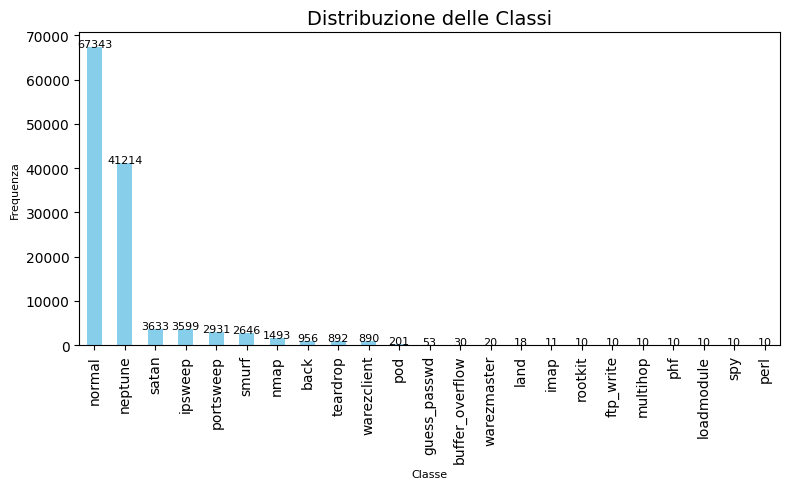

In [ ]:
import matplotlib.pyplot as plt

# Visualizza la distribuzione delle etichette nel dataset
plt.figure(figsize=(8, 5))
df_proc['label'].value_counts().plot(kind='bar', color='skyblue')

# Titolo e etichette sugli assi
plt.title("Distribuzione delle Classi", fontsize=14)
plt.xlabel("Classe", fontsize=8)
plt.ylabel("Frequenza", fontsize=8)

# Aggiungi le etichette sulle barre per visualizzare il conteggio
for i, v in enumerate(df_proc['label'].value_counts()):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=8)

# Mostra il grafico
plt.tight_layout()
plt.show()


applichiamo one hot

In [ ]:
print("primo dataset prima del one hot encoding: ",df_proc.shape)
df_proc.head()

primo dataset prima del one hot encoding:  (126000, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,tcp,ftp_data,SF,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,http,SF,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
3,0.0,tcp,http,SF,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
4,0.0,tcp,http,SF,2.079765e-07,1.718403e-06,0.0,0.0,0.0,0.0,...,0.858824,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00,normal


In [ ]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_proc.copy()  # Creazione di una copia separata

# Identificare le colonne categoriche
categorical_cols = ['protocol_type', 'service', 'flag', 'label']

# Applicare Label Encoding per mantenere il numero di colonne invariato
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le


In [ ]:
# Verificare il risultato
print("Dataset proc:", df_proc.shape)
print("Dataset ohe:", df_encoded.shape)

Dataset proc: (126000, 42)
Dataset ohe: (126000, 42)


In [ ]:

# Per ogni colonna categorica, crea una tabella con la mappatura
for col in categorical_cols:
    le = label_encoders[col]
    mapping_df = pd.DataFrame({
        "Encoded": list(range(len(le.classes_))),
        "Original": le.classes_
    })
    print(f"Mappatura per la colonna '{col}':")
    print(mapping_df.to_string(index=False))
    print("\n")

Mappatura per la colonna 'protocol_type':
 Encoded Original
       0     icmp
       1      tcp
       2      udp


Mappatura per la colonna 'service':
 Encoded    Original
       0         IRC
       1         X11
       2      Z39_50
       3         aol
       4        auth
       5         bgp
       6     courier
       7    csnet_ns
       8         ctf
       9     daytime
      10     discard
      11      domain
      12    domain_u
      13        echo
      14       eco_i
      15       ecr_i
      16         efs
      17        exec
      18      finger
      19         ftp
      20    ftp_data
      21      gopher
      22     harvest
      23   hostnames
      24        http
      25   http_2784
      26    http_443
      27   http_8001
      28       imap4
      29    iso_tsap
      30      klogin
      31      kshell
      32        ldap
      33        link
      34       login
      35         mtp
      36        name
      37 netbios_dgm
      38  netbios_ns
      39

In [ ]:
print("primo dataset")
df_proc.head()

primo dataset


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,tcp,ftp_data,SF,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,http,SF,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
3,0.0,tcp,http,SF,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
4,0.0,tcp,http,SF,2.079765e-07,1.718403e-06,0.0,0.0,0.0,0.0,...,0.858824,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00,normal


In [ ]:
print("label encoded dataset")
df_encoded.head()

label encoded dataset


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,1,20,9,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,11
1,0.0,2,44,9,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,11
2,0.0,1,24,9,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,11
3,0.0,1,24,9,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11
4,0.0,1,24,9,2.079765e-07,1.718403e-06,0.0,0.0,0.0,0.0,...,0.858824,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00,11


5. Removing Features Where Variation Is 0

In [ ]:
# Identify columns that have only one unique value
constant_features = [col for col in df_encoded.columns if df_encoded[col].nunique() == 1]
print("Features with zero variation:", constant_features)

# Drop these features from the train set
df_encoded.drop(columns=constant_features, inplace=True)
print(df_encoded.shape)


Features with zero variation: ['num_outbound_cmds']
(126000, 41)


matrice di correlazione per ridurre feature

In [ ]:

import seaborn as sns
from sklearn.model_selection import train_test_split
# Supponiamo che df_ready sia il tuo DataFrame
X = df_encoded.drop("label", axis=1)  # Carichiamo le caratteristiche
y = df_encoded["label"]  # Carichiamo le etichette


# Divisione iniziale tra training (70%) e il resto (30% per validazione e test)
X_train_cross, X_tmp, y_train_to_smote, y_tmp = train_test_split(X, y, test_size=0.3,
                                                  stratify=y, random_state=42)


# Ora suddividiamo il set rimanente in validation (10%) e test (20%):
# Dal 30% del totale, assegniamo 10% per la validazione e 20% per il test.
X_val_cross, X_test_cross, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=2/3,  # 2/3 di 30% è 20%, quindi il resto è 10%
                                                stratify=y_tmp, random_state=42)

# Stampa le dimensioni dei set
print(f"Training set size: {X_train_cross.shape[0]} samples")
print(f"Validation set size: {X_val_cross.shape[0]} samples")
print(f"Test set size: {X_test_cross.shape[0]} samples")

# Verifica la distribuzione delle classi nei vari set
print("\nClass distribution in the Training set:")
print(y_train_to_smote.value_counts())

print("\nClass distribution in the Validation set:")
print(y_val.value_counts())

print("\nClass distribution in the Test set:")
print(y_test.value_counts())



Training set size: 88200 samples
Validation set size: 12600 samples
Test set size: 25200 samples

Class distribution in the Training set:
label
11    47140
9     28850
17     2543
5      2519
15     2052
18     1852
10     1045
0       669
20      624
21      623
14      141
3        37
1        21
22       14
6        13
4         8
2         7
19        7
8         7
16        7
7         7
12        7
13        7
Name: count, dtype: int64

Class distribution in the Validation set:
label
11    6734
9     4121
17     363
5      360
15     293
18     265
10     149
0       96
20      89
21      89
14      20
3        6
1        3
22       2
6        2
16       1
4        1
7        1
12       1
2        1
13       1
19       1
8        1
Name: count, dtype: int64

Class distribution in the Test set:
label
11    13469
9      8243
17      727
5       720
15      586
18      529
10      299
0       191
20      179
21      178
14       40
3        10
1         6
22        4
6         3
8  

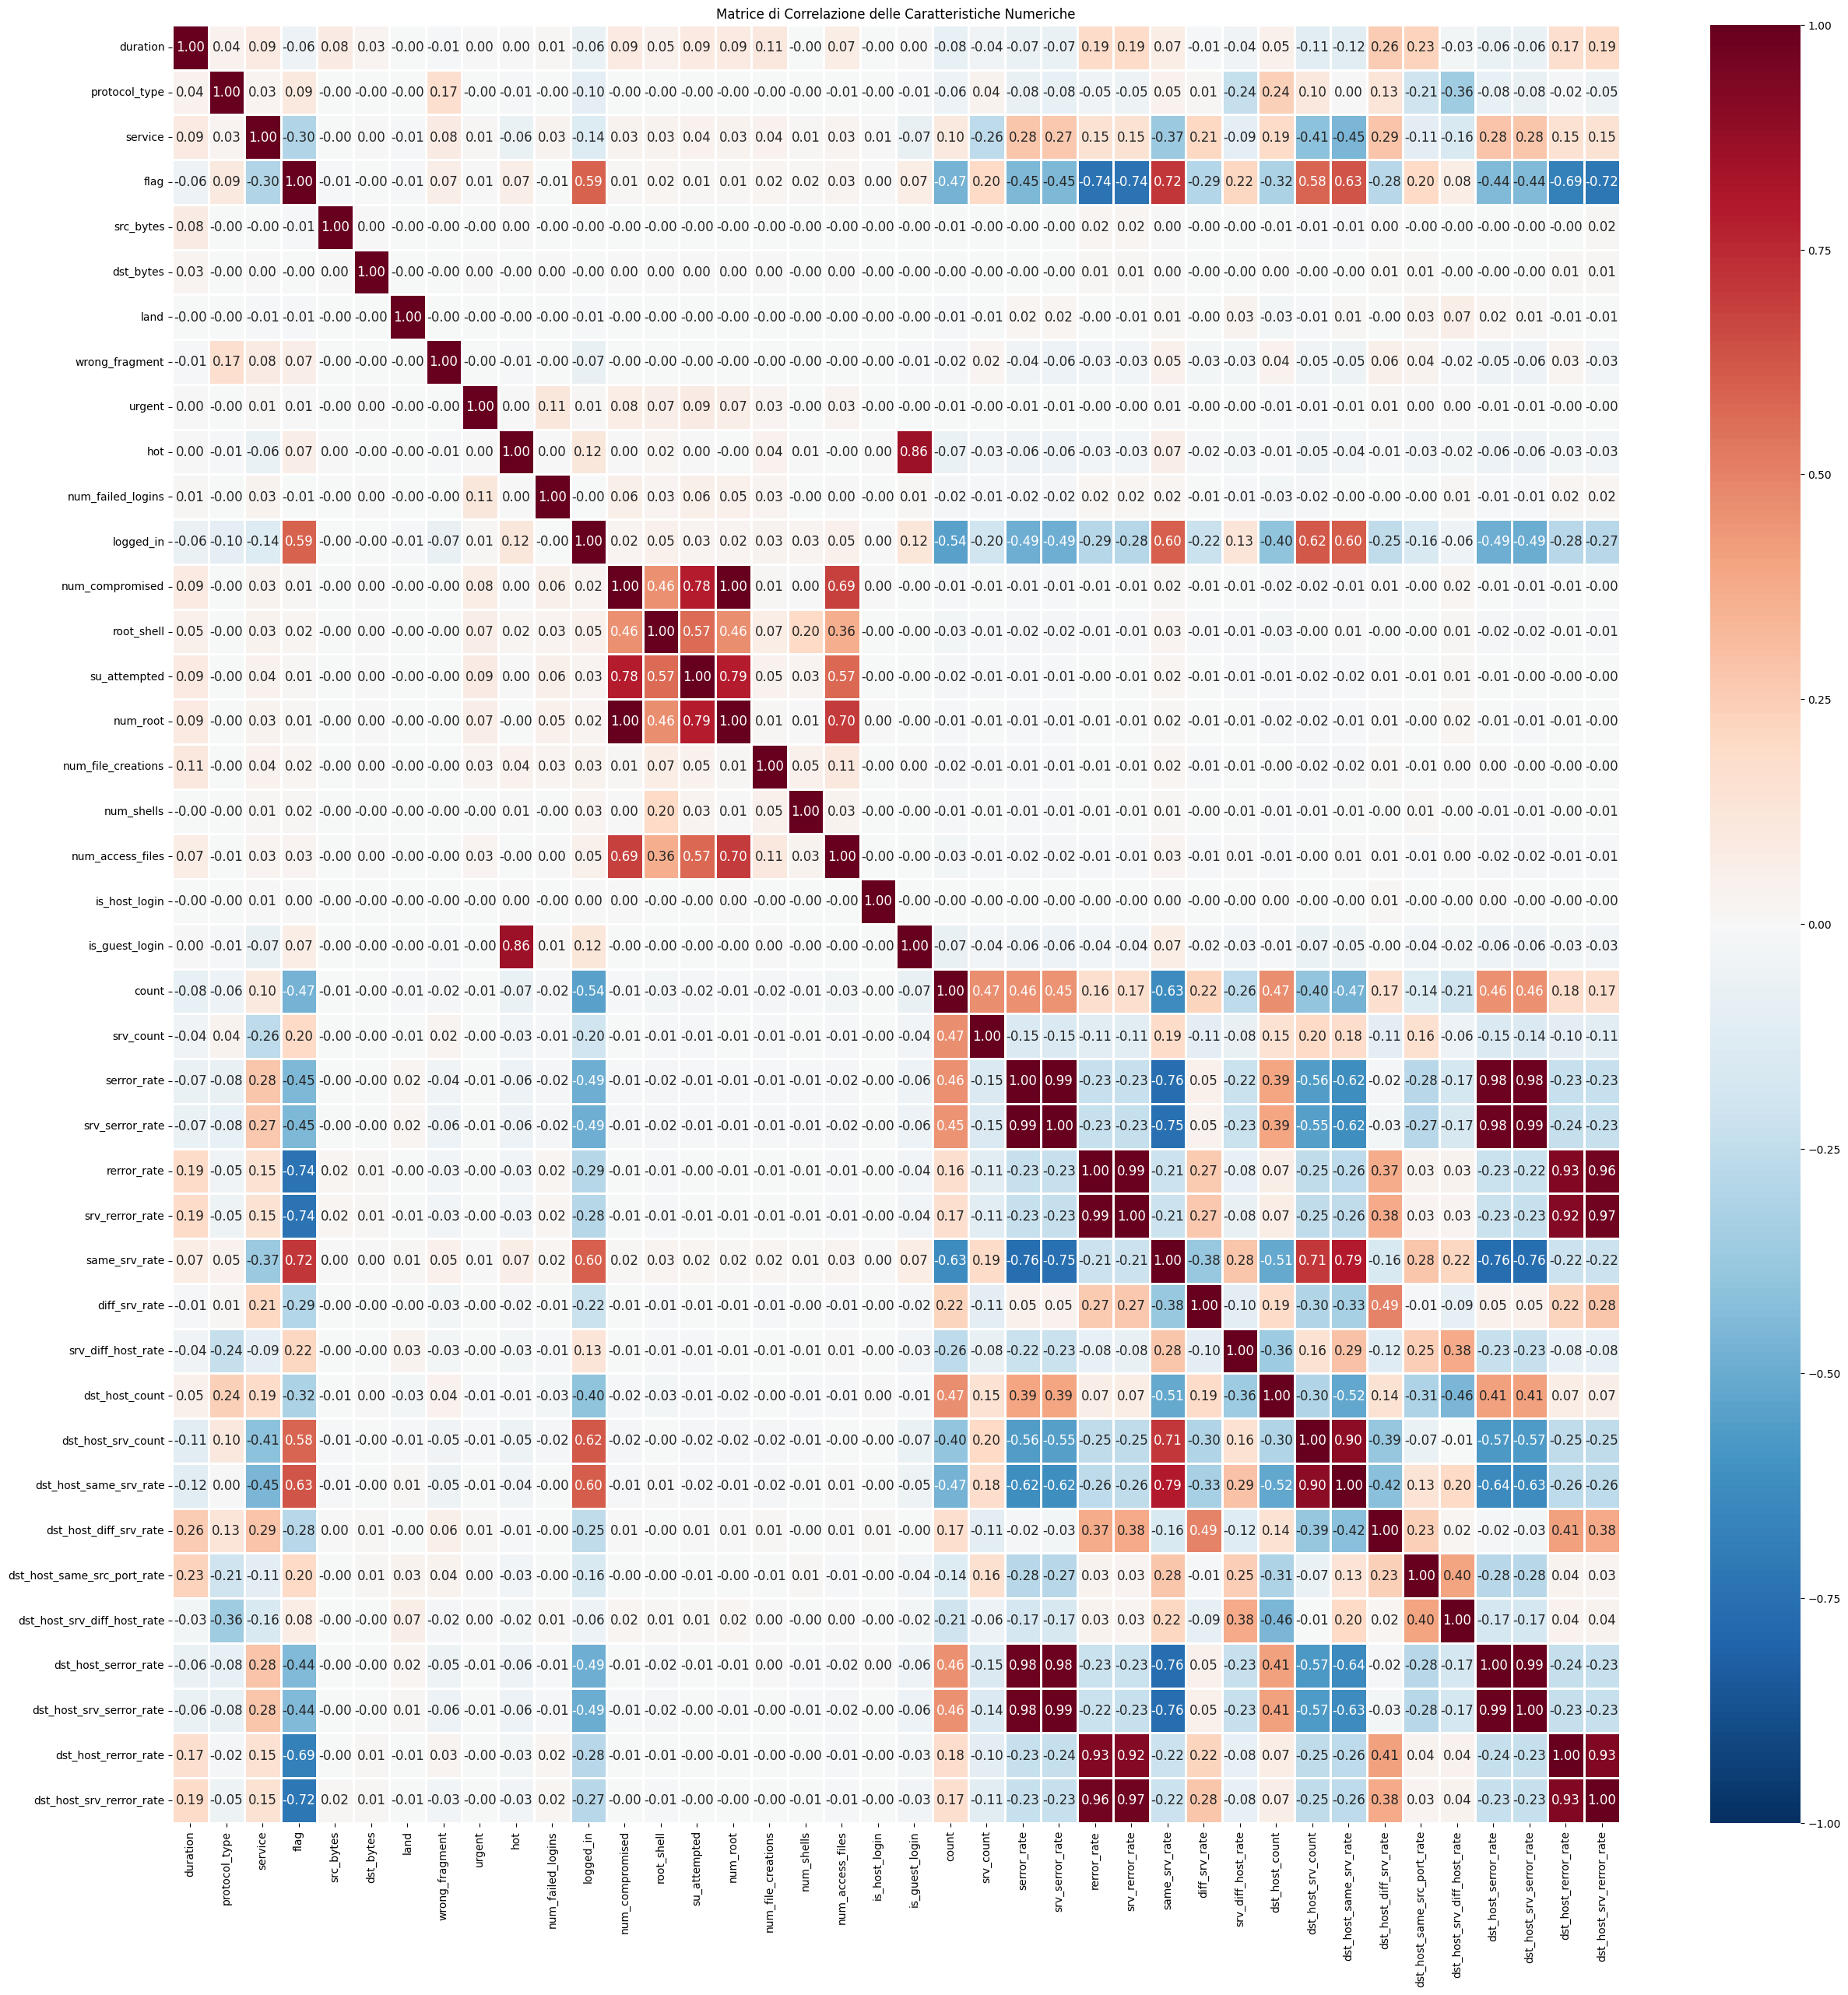

In [ ]:

# Calcola la matrice di correlazione
correlation_matrix = X_train_cross.corr()

# Crea la heatmap della matrice di correlazione
plt.figure(figsize=(30, 30))  # Aumentiamo la dimensione della figura
sns.heatmap(
    correlation_matrix,
    annot=True,                  # Mostra i valori nella heatmap
    fmt=".2f",                    # Limita i numeri a 2 decimali
    cmap="RdBu_r",                # Usa una mappa colori più leggibile
    linewidths=1,               # Linee di separazione tra le celle
    annot_kws={"size": 12},       # Imposta la dimensione del testo dei numeri
    vmin=-1, vmax=1               # Imposta il range della correlazione (-1 a 1)
)

# Aggiungi titolo
plt.title("Matrice di Correlazione delle Caratteristiche Numeriche")

# Mostra il grafico
plt.show()

In [ ]:
# Trova le colonne da eliminare
threshold = 0.95
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:  # Se la correlazione è maggiore della soglia
            colname = correlation_matrix.columns[i]  # Nome della colonna con alta correlazione
            to_drop.add(colname)

print("\n🚀 Feature da rimuovere:", to_drop)

# 📌 Step 3: Rimuovere le feature altamente correlate
X_train_to_smote = X_train_cross.drop(columns=to_drop)

X_val = X_val_cross.drop(columns=to_drop)

X_test = X_test_cross.drop(columns=to_drop)

print("\n✅ Dataset finale senza feature altamente correlate:")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


🚀 Feature da rimuovere: {'srv_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate', 'dst_host_serror_rate', 'srv_rerror_rate', 'num_root'}

✅ Dataset finale senza feature altamente correlate:
(88200, 34)
(12600, 34)
(25200, 34)


SMOTE

In [ ]:
# 1. Definisci una strategia di oversampling:
# Per ogni classe con meno di 50 campioni, SMOTE genererà campioni sintetici fino a raggiungere 50.
from collections import Counter
counts = Counter(y_train)
desired_count = 100
# Crea un dizionario che mappa le classi minoritarie al numero target di campioni
target_sampling = {cls: desired_count for cls, cnt in counts.items() if cnt < desired_count}
print("Strategia di oversampling target:", target_sampling)

# 2. Applica SMOTE con la sampling_strategy impostata come il dizionario target_sampling.
# Impostiamo k_neighbors=1 per evitare errori per le classi con pochissimi campioni.
from imblearn.over_sampling import SMOTE
smote_custom = SMOTE(sampling_strategy=target_sampling, random_state=42, k_neighbors=6)
X_train, y_train = smote_custom.fit_resample(X_train_to_smote, y_train_to_smote)
print("Frequenza delle classi dopo SMOTE con strategia personalizzata:", dict(Counter(y_train)))

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

# 1. Preprocessing: Applicazione One-Hot Encoding già fatto in precedenza
# Abbiamo già fatto il preprocessing con One-Hot Encoding, quindi possiamo usare direttamente X_train e X_test

# 2. Creazione del modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# 3. Definizione della griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None,20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy','log_loss'],
    'bootstrap': [True, False]
}


# 4. Creazione della grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=3)

# 5. Addestramento della grid search
grid_search.fit(X_train, y_train)  # Usa i dati preprocessati (One-Hot)

# 6. Migliori iperparametri trovati
print("Best parameters found: ", grid_search.best_params_)
# 7. Valutazione del modello sul validation set
best_rf = grid_search.best_estimator_
valid_predictions = best_rf.predict(X_val)  # Usa il validation set preprocessato
accuracy = accuracy_score(y_val, valid_predictions)
f1_macro_val = f1_score(y_val, valid_predictions, average='macro')
f1_weighted_val = f1_score(y_val, valid_predictions, average='weighted')
print("Validation set accuracy: ", accuracy)
print("Validation F1 Macro: ", f1_macro_val)
print("Validation F1 Weighted: ", f1_weighted_val)

# 8. Valutazione finale sul test set
test_predictions = best_rf.predict(X_test)  # Usa il test set preprocessato
test_accuracy_random_forest = accuracy_score(y_test, test_predictions)
f1_macro_test = f1_score(y_test, test_predictions, average='macro')
f1_weighted_test = f1_score(y_test, test_predictions, average='weighted')
print("Test set accuracy: ", test_accuracy_random_forest)
print("Test F1 Macro: ", f1_macro_test)
print("Test F1 Weighted: ", f1_weighted_test)


Fitting 2 folds for each of 96 candidates, totalling 192 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Validation set accuracy:  0.9984920634920635
Validation F1 Macro:  0.8094206352843412
Validation F1 Weighted:  0.9983140267657936
Test set accuracy:  0.9983730158730159
Test F1 Macro:  0.8208807664793983
Test F1 Weighted:  0.9982448314876777


creazione matrice confusione e verifica sul test

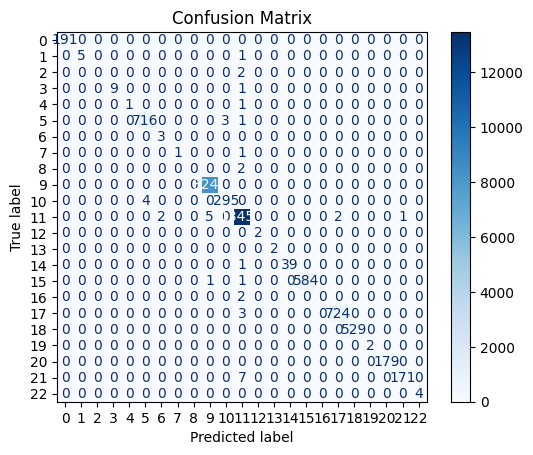

Confusion Matrix:
[[  191     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     9     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   716     0     0     0     0     3     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     3     0     0     0     0     0
      0     0     0     0     0     0     0     0 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Previsioni sul test set
test_predictions = best_rf.predict(X_test)

# Calcolare la confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Visualizzare la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues')  # 'Blues' è un colore chiaro e ben visibile per la visualizzazione
plt.title("Confusion Matrix")
plt.show()

# Stampa la confusion matrix numerica
print("Confusion Matrix:")
print(cm)

#f1score, precision, recall
report = classification_report(y_test, test_predictions)
print("Classification Report:")
print(report)

provo ad applicare pca

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# 1. I dati sono già preprocessati (One-Hot Encoding) e divisi in X_train, X_val, X_test, y_train, y_val, y_test

# 2. Creazione della pipeline che include StandardScaler, PCA e RandomForestClassifier
pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),                 # Riduce la dimensionalità
    ('rf', RandomForestClassifier(random_state=42))
])

# 3. Definizione della griglia degli iperparametri
# Aggiungiamo 'pca__n_components' per testare diverse riduzioni
param_grid = {
    'rf__n_estimators': [50,100],
    'rf__max_depth': [None,20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [2, 4],
    'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__bootstrap': [True, False]
}

# 4. Creazione della grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=2, n_jobs=-1, verbose=3)

# 5. Addestramento della grid search sul training set
grid_search.fit(X_train, y_train)  # Usa i dati preprocessati (One-Hot)

# 6. Migliori iperparametri trovati con PCA
print("Best parameters found with PCA: ", grid_search.best_params_)

# 7. Valutazione del modello sul validation set
best_rf_pca = grid_search.best_estimator_
valid_predictions = best_rf_pca.predict(X_val)  # Usa il validation set preprocessato dalla pipeline
accuracy_val = accuracy_score(y_val, valid_predictions)
print("Validation set accuracy (with PCA): ", accuracy_val)

# 8. Valutazione finale sul test set
test_predictions = best_rf_pca.predict(X_test)  # Usa il test set preprocessato dalla pipeline
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test set accuracy (with PCA): ", test_accuracy)




Fitting 2 folds for each of 96 candidates, totalling 192 fits


KeyboardInterrupt: 

confronto i due modelli

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Senza PCA: supponiamo tu abbia già il modello best_rf (Random Forest senza PCA)
rf_pred = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1_macro = f1_score(y_test, rf_pred, average='macro')
print("Random Forest senza PCA:")
print("Accuracy:", rf_accuracy)
print("F1 Macro:", rf_f1_macro)
print(classification_report(y_test, rf_pred))

# Con PCA: usa il modello ottenuto dalla pipeline con PCA
# Qui assumiamo che tu abbia definito best_rf_pca = grid_search.best_estimator_ dal modello con PCA
rf_pca_pred = best_rf_pca.predict(X_test)
rf_pca_accuracy = accuracy_score(y_test, rf_pca_pred)
rf_pca_f1_macro = f1_score(y_test, rf_pca_pred, average='macro')
print("Random Forest con PCA:")
print("Accuracy:", rf_pca_accuracy)
print("F1 Macro:", rf_pca_f1_macro)
print(classification_report(y_test, rf_pca_pred))

Random Forest senza PCA:
Accuracy: 0.977340370649629
F1 Macro: 0.37524186753609146
              precision    recall  f1-score   support

           0       1.00      0.86      0.93       191
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         2
           5       0.86      0.93      0.90       720
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00      8243
          10       1.00      0.49      0.66       299
          11       0.97      1.00      0.98     13469
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       1.00      0.17      0.30        40
          15       0.95      0.98      0.97       58

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest con PCA:
Accuracy: 0.9637684035080757
F1 Macro: 0.3658623441042034
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       191
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         2
           5       1.00      0.85      0.92       720
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00      8243
          10       0.95      0.81      0.88       299
          11       0.94      1.00      0.97     13469
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       1.00      0.88      0.93        40
          15       0.98      0.93      0.96       586


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Miglioramento con il pesare i pesi

In [ ]:
# Modello con class_weight bilanciato senza applicare PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Definizione del modello con class_weight bilanciato
rf_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid_weighted = {
    'n_estimators': [50,100],
    'max_depth': [None,20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False]
}

# 2. Grid Search per ottimizzare i parametri
grid_search_weighted = GridSearchCV(estimator=rf_weighted, param_grid=param_grid_weighted, cv=3, n_jobs=-1, verbose=3)
grid_search_weighted.fit(X_train, y_train)

best_rf_weighted = grid_search_weighted.best_estimator_

# 3. Valutazione sul Validation set
val_predictions_weighted = best_rf_weighted.predict(X_val)
print("Validation set accuracy (con class_weight bilanciato):", accuracy_score(y_val, val_predictions_weighted))

# 4. Valutazione finale sul Test set
test_predictions_weighted = best_rf_weighted.predict(X_test)
print("Test set accuracy (con class_weight bilanciato):", accuracy_score(y_test, test_predictions_weighted))
print("Classification Report (con class_weight bilanciato):")
print(classification_report(y_test, test_predictions_weighted))

# 5. Visualizzazione della Confusion Matrix
cm_weighted = confusion_matrix(y_test, test_predictions_weighted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=best_rf_weighted.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Con Class Weighting")
plt.show()

# 6. Calcolo e plot degli F1 Score per ciascuna classe sul Test set
f1_per_class = f1_score(y_test, test_predictions_weighted, average=None)
classes = best_rf_weighted.classes_

plt.figure(figsize=(10, 6))
plt.bar(classes, f1_per_class, color='steelblue')
plt.xlabel('Classe')
plt.ylabel('F1 Score')
plt.title('F1 Score per Classe (Test Set) - Con Class Weighting')
plt.xticks(classes, rotation=45)
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

NameError: name 'X_train' is not defined

PROVO AD USARE ALTRI PESI

In [ ]:
# Funzione per calcolare i pesi personalizzati
def compute_custom_weights(y, rare_threshold, rare_multiplier):
    """
    Calcola pesi personalizzati in base alla radice quadrata dell'inverso della frequenza.
    Se una classe ha meno campioni di rare_threshold, il suo peso viene moltiplicato per rare_multiplier.

    Parameters:
        y : array-like
            Etichette del training set.
        rare_threshold : int, optional
            Soglia sotto la quale la classe viene considerata rara.
        rare_multiplier : float, optional
            Fattore moltiplicativo da applicare alle classi rare.

    Returns:
        dict: Dizionario con i pesi per ogni classe.
    """
    from collections import Counter
    import numpy as np
    counts = Counter(y)
    max_count = max(counts.values())
    weights = {}
    for cls, count in counts.items():
        base_weight = np.sqrt(max_count / count)
        # Applica un moltiplicatore se la classe è considerata rara
        if count < rare_threshold:
            base_weight *= rare_multiplier
        weights[cls] = base_weight
    return weights

# Calcola i pesi personalizzati per y_train
custom_weights = compute_custom_weights(y_train, rare_threshold=20, rare_multiplier=8)
print("Frequenza delle classi:", dict(__import__('collections').Counter(y_train)))
print("Pesi personalizzati:", custom_weights)

# --- Punto in cui integri i pesi nel modello ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definisci il modello RandomForest usando i pesi personalizzati
rf_model = RandomForestClassifier(random_state=42, class_weight=custom_weights)

# Definisci una griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy','log_loss'],
    'bootstrap': [True, False]
}

# Esegui Grid Search
grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Migliori iperparametri trovati:", grid_search.best_params_)

# --- Valutazione del modello ---

from sklearn.metrics import accuracy_score, classification_report, f1_score

# Valutazione sul validation set
val_pred = grid_search.predict(X_val)
print("Accuratezza sul validation set:", accuracy_score(y_val, val_pred))
print("Classification Report sul validation set:")
print(classification_report(y_val, val_pred))
print("F1 Macro sul validation set:", f1_score(y_val, val_pred, average='macro'))
print("F1 Weighted sul validation set:", f1_score(y_val, val_pred, average='weighted'))

# Valutazione sul test set
test_pred = grid_search.predict(X_test)
print("Accuratezza sul test set:", accuracy_score(y_test, test_pred))
print("Classification Report sul test set:")
print(classification_report(y_test, test_pred))
print("F1 Macro sul test set:", f1_score(y_test, test_pred, average='macro'))
print("F1 Weighted sul test set:", f1_score(y_test, test_pred, average='weighted'))




ORA VADO A FARE OVERSALMPLING MIRATO CON SMOTE

In [ ]:
# --- Oversampling mirato con SMOTE "personalizzato" ispirato a traccia 7 ---

# 1. Definisci una strategia di oversampling:
# Per ogni classe con meno di 50 campioni, SMOTE genererà campioni sintetici fino a raggiungere 50.
from collections import Counter
counts = Counter(y_train)
desired_count = 80
# Crea un dizionario che mappa le classi minoritarie al numero target di campioni
target_sampling = {cls: desired_count for cls, cnt in counts.items() if cnt < desired_count}
print("Strategia di oversampling target:", target_sampling)

# 2. Applica SMOTE con la sampling_strategy impostata come il dizionario target_sampling.
# Impostiamo k_neighbors=1 per evitare errori per le classi con pochissimi campioni.
from imblearn.over_sampling import SMOTE
smote_custom = SMOTE(sampling_strategy=target_sampling, random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote_custom.fit_resample(X_train, y_train)
print("Frequenza delle classi dopo SMOTE con strategia personalizzata:", dict(Counter(y_train_smote)))

# 3. (Opzionale) Puoi ancora calcolare i pesi personalizzati come prima, se vuoi
custom_weights = compute_custom_weights(y_train, rare_threshold=15, rare_multiplier=4)
print("Pesi personalizzati:", custom_weights)

# 4. Definisci il modello RandomForest con i pesi personalizzati
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, class_weight=custom_weights)

# 5. Definisci la griglia degli iperparametri
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False]
}

# 6. Esegui Grid Search utilizzando il training set oversamplato con la strategia personalizzata
grid_search_custom = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_custom.fit(X_train_smote, y_train_smote)
best_rf=grid_search_custom.best_estimator_
print("Migliori iperparametri trovati:", grid_search_custom.best_params_)

# 7. Valuta il modello sul validation e test set
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Validation set
val_pred_custom = grid_search_custom.predict(X_val)
print("Accuratezza sul validation set:", accuracy_score(y_val, val_pred_custom))
print("Classification Report sul validation set:")
print(classification_report(y_val, val_pred_custom))
print("F1 Macro sul validation set:", f1_score(y_val, val_pred_custom, average='macro'))
print("F1 Weighted sul validation set:", f1_score(y_val, val_pred_custom, average='weighted'))

# Test set
test_pred_custom = grid_search_custom.predict(X_test)
print("Accuratezza sul test set:", accuracy_score(y_test, test_pred_custom))
print("Classification Report sul test set:")
print(classification_report(y_test, test_pred_custom))
print("F1 Macro sul test set:", f1_score(y_test, test_pred_custom, average='macro'))
print("F1 Weighted sul test set:", f1_score(y_test, test_pred_custom, average='weighted'))



CALIBRAZIONE DELLA TRESHOLD

In [ ]:
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, f1_score

# Supponiamo che grid_search_custom sia il tuo modello addestrato (con GridSearchCV)
# e X_val, y_val siano il validation set originali.

# 1. Calcola i predicted probabilities sul validation set
probs_val = grid_search_custom.predict_proba(X_val)

# 2. Definisci quali classi sono considerate rare (ad es. quelle con count < 20 nel dataset originale)
original_counts = Counter(y_train)  # usiamo il dataset originale
rare_classes = {cls for cls, cnt in original_counts.items() if cnt < 20}
print("Classi rare (count < 20):", rare_classes)

# 3. Definisci soglie personalizzate: ad esempio, per le classi rare usa una soglia più bassa (0.2)
# e per le classi non rare usa la soglia standard di argmax.
rare_threshold = 0.2

# 4. Crea una funzione custom di predizione:
def custom_predict(probs, rare_classes, rare_threshold=0.2):
    """
    Per ogni campione, controlla se una classe rara (in rare_classes)
    ha una probabilità superiore a rare_threshold.
    Se sì, assegna quella classe (se ne ce ne sono più di una, sceglie quella con maggiore probabilità);
    altrimenti, assegna la classe con la probabilità massima (argmax).
    """
    preds = []
    for prob_vec in probs:
        # Trova le classi rare con prob > rare_threshold
        rare_candidates = {i: p for i, p in enumerate(prob_vec) if i in rare_classes and p >= rare_threshold}
        if rare_candidates:
            # Se ci sono candidati, scegli quello con la probabilità massima
            pred = max(rare_candidates, key=rare_candidates.get)
        else:
            # Altrimenti, assegna la classe con la massima probabilità
            pred = np.argmax(prob_vec)
        preds.append(pred)
    return np.array(preds)

# Nota: Se le tue classi sono codificate come stringhe, devi avere una mappatura;
# qui assumiamo che grid_search_custom.predict_proba restituisca una matrice con indici corrispondenti.

# 5. Applica la funzione di predizione custom sul validation set
custom_val_preds = custom_predict(probs_val, rare_classes, rare_threshold=rare_threshold)

# 6. Valuta le performance sul validation set con il nuovo meccanismo di decisione
print("Custom Classification Report sul validation set (con soglie calibrate):")
print(classification_report(y_val, custom_val_preds, zero_division=0))
print("Custom F1 Macro sul validation set:", f1_score(y_val, custom_val_preds, average='macro'))
print("Custom F1 Weighted sul validation set:", f1_score(y_val, custom_val_preds, average='weighted'))

# Se i risultati sono promettenti, ripeti lo stesso procedimento sul test set:
probs_test = grid_search_custom.predict_proba(X_test)
custom_test_preds = custom_predict(probs_test, rare_classes, rare_threshold=rare_threshold)
print("Custom Classification Report sul test set (con soglie calibrate):")
print(classification_report(y_test, custom_test_preds, zero_division=0))
print("Custom F1 Macro sul test set:", f1_score(y_test, custom_test_preds, average='macro'))
print("Custom F1 Weighted sul test set:", f1_score(y_test, custom_test_preds, average='weighted'))


# LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Creazione del modello di regressione logistica
lr = LogisticRegression(random_state=42, max_iter=100)

# Definizione della griglia degli iperparametri per la regressione logistica
param_grid_logreg = [
    {'C': [0.01, 0.1, 1, 10, 100],  # termine di regolarizzazione
     'solver': ['liblinear'],
     'penalty': ['l1', 'l2']},
    {'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['saga'],
     'penalty': ['l1', 'l2', 'elasticnet'],
     'l1_ratio': [0.5]},  # 'l1_ratio' è necessario per elasticnet
    {'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'],
     'penalty': ['l2']}
]

# Creazione della grid search per la regressione logistica
grid_search_logreg = GridSearchCV(estimator=lr, param_grid=param_grid_logreg, cv=3, n_jobs=-1, verbose=3)


training

In [ ]:
# Addestramento della grid search
grid_search_logreg.fit(X_train, y_train)

# Migliori iperparametri trovati
print("Best parameters found: ", grid_search_logreg.best_params_)

# 7. Valutazione del modello sul validation set
best_lr = grid_search.best_estimator_
valid_predictions = best_lr.predict(X_val)  # Usa il validation set preprocessato
accuracy = accuracy_score(y_val, valid_predictions)
print("Validation set accuracy: ", accuracy)

In [ ]:
# 8. Valutazione finale sul test set
test_predictions = best_lr.predict(X_test)  # Usa il test set preprocessato
test_accuracy_random_forest = accuracy_score(y_test, test_predictions)
print("Test set accuracy: ", test_accuracy_random_forest)

confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Previsioni sul test set
y_pred = best_lr.predict(X_test)

# Calcolare la confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizzare la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lr.classes_)
disp.plot(cmap='Blues')  # 'Blues' è un colore chiaro e ben visibile per la visualizzazione
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Stampa la confusion matrix numerica
print("Confusion Matrix:")
print(cm)


ciìonfronto

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Previsioni con il modello Random Forest
rf_pred = best_rf.predict(X_test)

# Previsioni con il modello Logistic Regression
lr_pred = best_lr.predict(X_test)

# 1. Accuratezza di entrambi i modelli
rf_accuracy = accuracy_score(y_test, rf_pred)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# 2. Classification Report (Precision, Recall, F1-Score)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))

# 3. Confusion Matrix per Random Forest
rf_cm = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=best_rf.classes_)
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# 4. Confusion Matrix per Logistic Regression
lr_cm = confusion_matrix(y_test, lr_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=best_lr.classes_)
disp_lr.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# 5. Confronto visivo tra le confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Random Forest
ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=best_rf.classes_).plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Random Forest Confusion Matrix")

# Plot Logistic Regression
ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=best_lr.classes_).plot(ax=ax[1], cmap='Blues')
ax[1].set_title("Logistic Regression Confusion Matrix")

plt.tight_layout()
plt.show()


# PCA

separo target dalle feature

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)  # Solo le features vengono normalizzate

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,20,9,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,44,9,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,1,49,5,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,1,24,9,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,24,9,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


pca con 95% di varianza

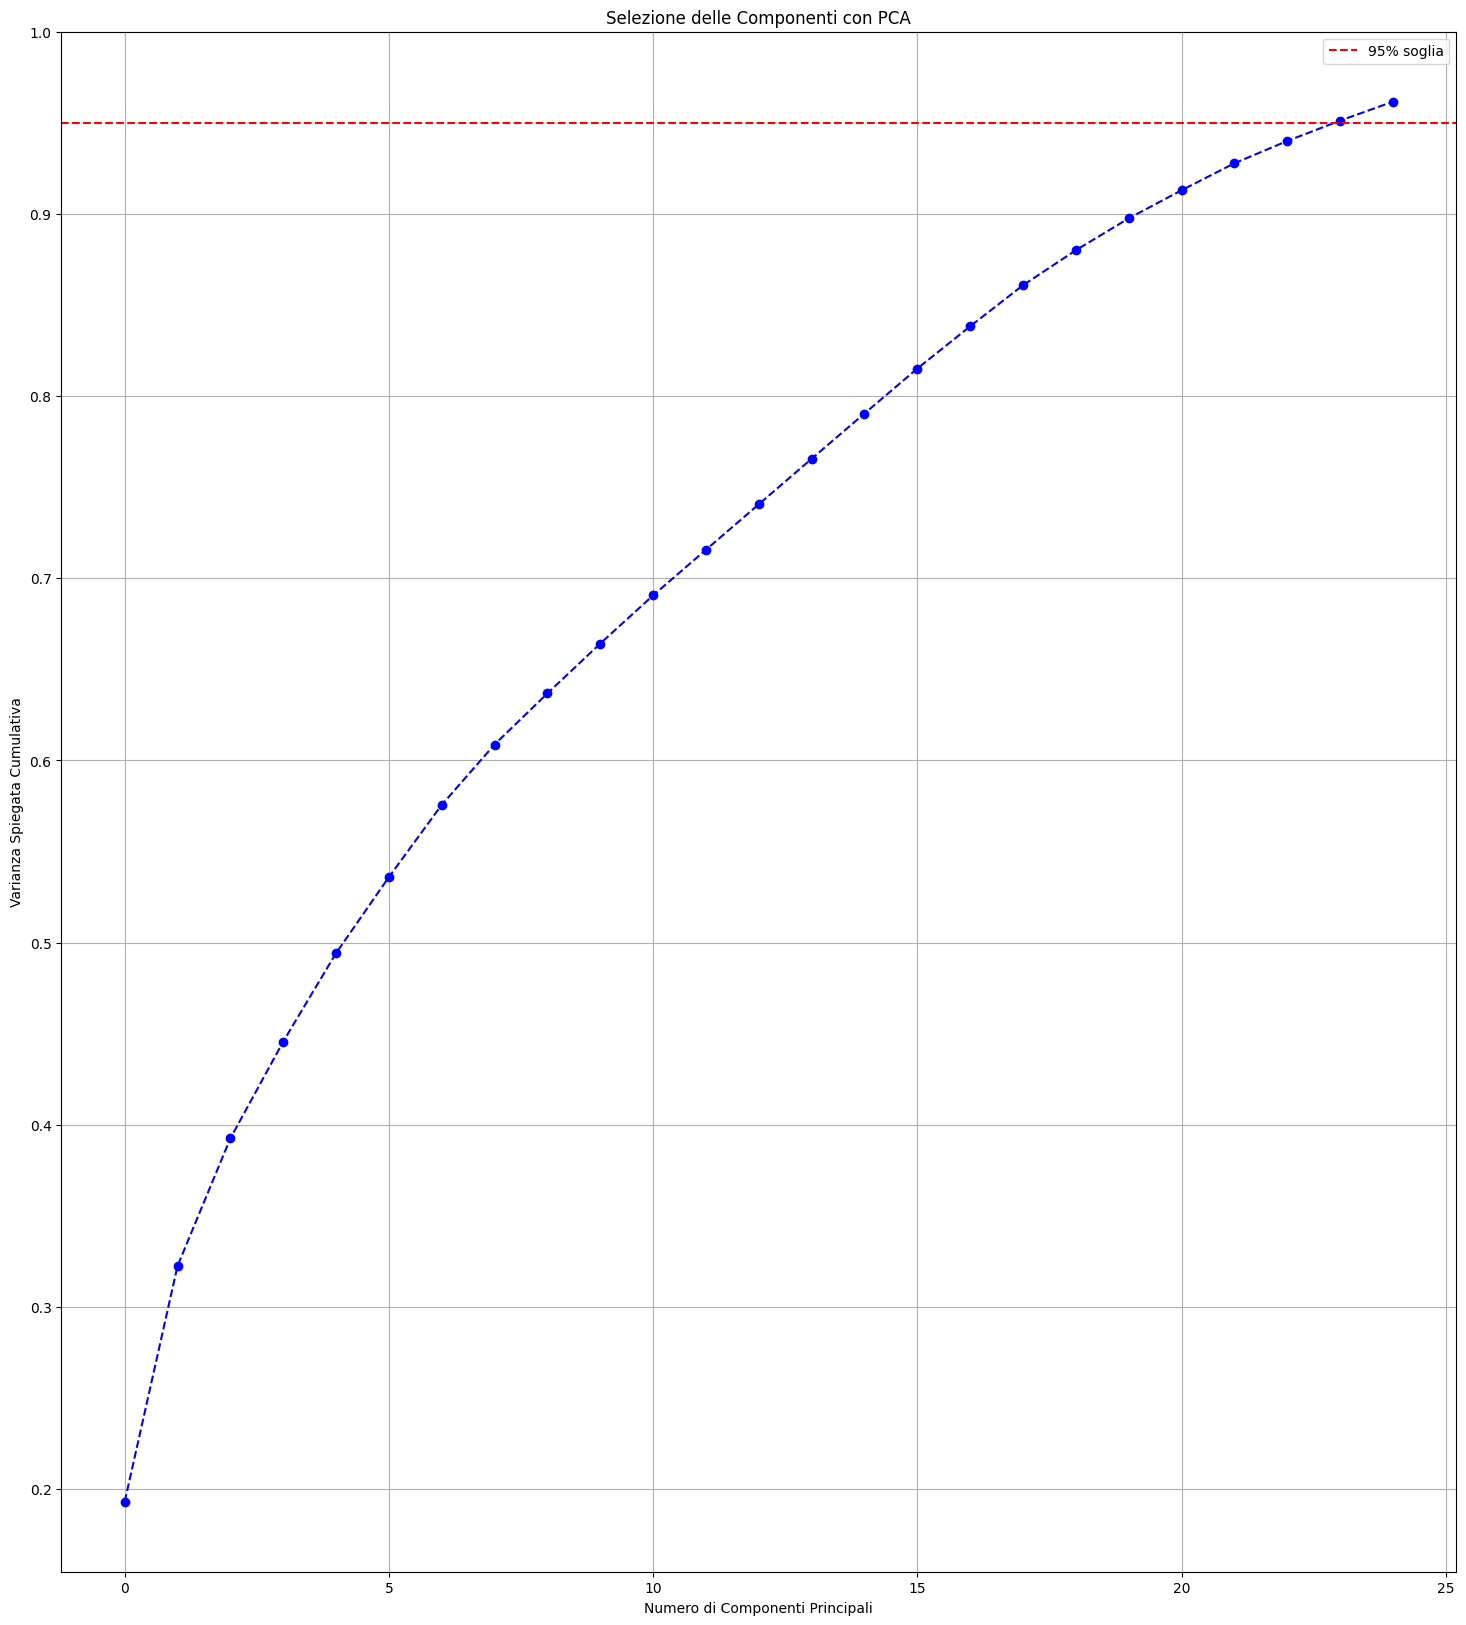

✅ Numero di componenti selezionate: 25
✅ Dataset trasformato con PCA: (125991, 26)


In [ ]:
# 📌 2️⃣ PCA con varianza spiegata del 95% (Selezione automatica componenti)
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.fit_transform(X_val_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

# 📌 3️⃣ Creiamo un DataFrame con le nuove feature PCA
pca_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
df_train_pca = pd.DataFrame(X_train_pca, columns=pca_columns)

# ✅ Reinseriamo la colonna target
df_train_pca["label"] = y_train.values

# 📌 4️⃣ Grafico della varianza spiegata cumulativa
plt.figure(figsize=(18, 20))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% soglia")
plt.xlabel("Numero di Componenti Principali")
plt.ylabel("Varianza Spiegata Cumulativa")
plt.title("Selezione delle Componenti con PCA")
plt.legend()
plt.grid()
plt.show()

# 📊 Stampiamo il numero di componenti selezionate automaticamente
print(f"✅ Numero di componenti selezionate: {X_train_pca.shape[1]}")
print(f"✅ Numero di componenti selezionate: {X_val_pca.shape[1]}")
print(f"✅ Numero di componenti selezionate: {X_test_pca.shape[1]}")
print("✅ Dataset trasformato con PCA:", df_train_pca.shape)

#CNN

##CNN CROSS

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input di 35 feature, rimodellato in 7x5 (1 canale)
input_layer_cross = layers.Input(shape=(35,))
reshaped = layers.Reshape((7, 5, 1))(input_layer_cross)

# Primo strato di convoluzione
conv1 = layers.Conv2D(6, (3,3), activation='tanh', padding='same')(reshaped)
pool1 = layers.AveragePooling2D((2,2))(conv1)

# Secondo strato di convoluzione
conv2 = layers.Conv2D(16, (2,2), activation='tanh', padding='same')(pool1)
pool2 = layers.AveragePooling2D((2,2))(conv2)

# Flatten e Fully Connected
flatten = layers.Flatten()(pool2)
dense1 = layers.Dense(120, activation='tanh')(flatten)
dense2 = layers.Dense(84, activation='tanh')(dense1)
output = layers.Dense(23, activation='softmax')(dense2)  # modifica il numero di unità secondo le tue classi

model_smote_cross = models.Model(inputs=input_layer_cross, outputs=output)
model_smote_cross.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_smote_cross.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 5, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 5, 5, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 5, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 23)                  │           1,495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,759 (143.59 KB)

 Trainable params: 36,759 (143.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Ora puoi usare class_weight_dict nel fit
history_smote_cross = model_smote_cross.fit(
    X_train_smote_cross, y_train_smote_cross,
    epochs=50,            # Numero massimo di epoche
    batch_size=16,        # Numero di campioni per batch
    validation_data=(X_val_reduced, y_val),  # Dati di validazione
    callbacks=[early_stopping],  # Applichiamo Early Stopping
    verbose=1,            # Stampa i dettagli durante il training  # Pesi per le classi bilanciati
)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_true = y_test
# Ottieni le predizioni
y_pred_prob = model_smote_cross.predict(X_test_reduced)
y_pred = np.argmax(y_pred_prob, axis=1)

# Genera il report
report_smote_cross = classification_report(y_true, y_pred)
print(report_smote_cross)

##CNN PCA

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input di 25 feature, rimodellato in 5x5 (1 canale)
input_layer = layers.Input(shape=(24,))
reshaped = layers.Reshape((6, 4, 1))(input_layer)

# Poiché l'immagine è molto piccola, kernel piccoli sono consigliabili.
conv1 = layers.Conv2D(6, (3,3), activation='tanh', padding='same')(reshaped)
pool1 = layers.AveragePooling2D((2,2))(conv1)

conv2 = layers.Conv2D(16, (2,2), activation='tanh', padding='same')(pool1)
pool2 = layers.AveragePooling2D((2,2))(conv2)

# Flatten e Fully Connected
flatten = layers.Flatten()(pool2)
dense1 = layers.Dense(120, activation='tanh')(flatten)
dense2 = layers.Dense(84, activation='tanh')(dense1)
output = layers.Dense(23, activation='softmax')(dense2)  # modifica il numero di unità secondo le tue classi

model_smote = models.Model(inputs=input_layer, outputs=output)
model_smote.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_smote.summary()


In [ ]:
# Ora puoi usare class_weight_dict nel fit
history_smote_pca = model_smote.fit(
    X_train_smote_pca, y_train_smote_pca,
    epochs=50,            # Numero massimo di epoche
    batch_size=32,        # Numero di campioni per batch
    validation_data=(X_val_pca, y_val),  # Dati di validazione
    callbacks=[early_stopping],  # Applichiamo Early Stopping
    verbose=1,            # Stampa i dettagli durante il training  # Pesi per le classi bilanciati
)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_true = y_test
# Ottieni le predizioni
y_pred_prob = model_smote.predict(X_test_pca)
y_pred = np.argmax(y_pred_prob, axis=1)

# Genera il report
report_pca = classification_report(y_true, y_pred)
print(report_pca)

# Opzionale: genera una matrice di confusione
cm_cross = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cross, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Etichetta Predetta")
plt.ylabel("Etichetta Vera")
plt.title("Matrice di Confusione")
plt.show()